In [1]:
# GPT Model
import torch
import torch.nn as nn

GPT_CONFIG_124M = { 
    "vocab_size": 50257, 
    "context_length": 256, #1024, 
    "emb_dim": 768, 
    "n_heads": 12, 
    "n_layers": 4, #12,  # Transformer-Block-Layers
    "drop_rate": 0.1, 
    "qkv_bias": False
}

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.eps = 1e-5
    
    def forward(self, x: torch.Tensor):
        '''x: 3D Tensor'''
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True, unbiased=False) # unbiased=False => Division by `n`, rather than `n-1`
        std = x.std(-1, keepdim=True)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return (x_norm * self.scale + self.shift)

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config['emb_dim'], 4 * config['emb_dim']),
            GELU(),
            nn.Linear( 4 * config['emb_dim'], config['emb_dim'])
        )
    
    def forward(self, x):
        return self.layers(x)

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return (0.5 * x * (1 + torch.tanh(
            (torch.sqrt(torch.tensor(2/torch.pi))) + (x + 0.044715 * torch.pow(x, 3))
        )))

class MultiheadAttention(nn.Module):
    def __init__(self, d_in, d_out, n_heads, context_length, dropout=0.5, qkv_bias=False):
        super().__init__()
        assert (d_out % n_heads == 0)

        self.d_in = d_in
        self.d_out = d_out
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.d_head = (d_out // n_heads)
        self.n_heads = n_heads
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(d_out, d_out)
        self.register_buffer('mask', torch.ones(context_length, context_length).triu(1).bool())
    
    def forward(self, x):
        '''x: 3D. x => (batch_size, num_tokens, token_embed)'''
        b, n_tokens, token_embed = x.shape
        assert self.d_in == token_embed
        
        Q = self.W_q(x) # (b, n_tokens, d_out)
        K = self.W_k(x)
        V = self.W_v(x)

        Q = Q.view(b, n_tokens, self.n_heads, self.d_head) # (b, n_tokens, n_heads, d_head)
        K = K.view(b, n_tokens, self.n_heads, self.d_head) 
        V = V.view(b, n_tokens, self.n_heads, self.d_head) 

        Q = Q.transpose(1, 2) # (b, n_heads, n_tokens, d_head)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        attn_scores = torch.matmul(Q, K.transpose(-1, -2)) / self.d_head**0.5 #K.shape[-1]**0.5
        attn_scores = attn_scores.masked_fill(self.mask[: n_tokens, : n_tokens], -torch.inf)
        attn_weights = attn_scores.softmax(-1)
        attn_weights = self.dropout(attn_weights)
        context_vectors = attn_weights @ V
        context_vectors = context_vectors.transpose(1, 2)
        context_vectors = context_vectors.contiguous().view(b, n_tokens, self.d_out)
        return self.out_proj(context_vectors)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiheadAttention(
            d_in=cfg['emb_dim'],    # 768
            d_out=cfg['emb_dim'],   # 768
            n_heads=cfg['n_heads'], # 12
            context_length=cfg['context_length'], # 1024
            dropout=cfg['drop_rate'], # 0.1
            qkv_bias=cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.norm_1 = LayerNorm(cfg['emb_dim'])
        self.norm_2 = LayerNorm(cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['drop_rate'])
    
    def forward(self, x):
        # Part 1:
        shortcut = x
        x = self.norm_1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = x + shortcut

        # Part 2:
        shortcut = x
        x = self.norm_2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + shortcut
        return x

class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.tok_emb = nn.Embedding(config['vocab_size'], config['emb_dim'])
        self.pos_emb = nn.Embedding(config['context_length'], config['emb_dim'])
        self.drop_emb = nn.Dropout(config['drop_rate'])
        self.transf_layers = nn.Sequential(*[TransformerBlock(config) for _ in range(config['n_layers'])])
        self.final_norm = LayerNorm(config['emb_dim'])
        self.out_head = nn.Linear(config['emb_dim'], config['vocab_size'], bias=False)
    
    def forward(self, x, show_info=False):
        '''x: 2D Matrix'''
        batch_size, seq_len = x.shape 
        tok_emb = self.tok_emb(x) 
        pos_emb = self.pos_emb(
            torch.arange(seq_len).to(x.device)  # Ensure pos indices are on the same device as x
        )
        x = tok_emb + pos_emb
        if show_info:
            print(f'Token-Embed(shape): {tok_emb.shape}')
            print(f'POS-Embed(shape): {pos_emb.shape}')
            print(f'i/p Before TransfBlocks(shape): {x.shape}')
        x = self.drop_emb(x)
        x = self.transf_layers(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [2]:
model = GPTModel(GPT_CONFIG_124M)

In [ ]:
# COLAB: Download the-verdict.txt:
import requests
url = 'https://github.com/rasbt/LLMs-from-scratch/blob/main/ch02/01_main-chapter-code/the-verdict.txt' #'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
response = requests.get(url)
raw_txt = response.text

: 

In [ ]:
len(raw_txt)

210002

: 

In [2]:
# Raw-Text
FILE_PATH = '../../ch02/01_main-chapter-code/the-verdict.txt'
with open(FILE_PATH, 'r') as f:
    raw_txt = f.read()
raw_txt

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)\n\n"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it\'s going to send the value of my picture \'way up; but I don\'t think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing\'s lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn\'s "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?\n\nWell!--even 

In [3]:
from torch.utils.data import Dataset, DataLoader
import tiktoken

class GPTDatasetV1(Dataset):
    def __init__(self, raw_text, tokenizer: tiktoken.Encoding, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        encodings = tokenizer.encode(raw_text, allowed_special={"<|endoftext|>"})
        for i in range(0, len(encodings) - max_length, stride):
            input_chunk = encodings[i : i+max_length]
            target_chunk = encodings[i+1 : i+1+max_length]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids) 
    
    def __getitem__(self, idx):
        return (self.input_ids[idx], self.target_ids[idx])

def create_dataloaded(raw_text, tokenizer, max_length, stride, batch_size, shuffle=True, drop_last=True, num_workers=0):
    dataset = GPTDatasetV1(raw_text, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset=dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        drop_last=drop_last, 
        num_workers=num_workers)
    return dataloader

split_ratio = 0.8
split_idx = int(len(raw_txt) * split_ratio)
train_txt = raw_txt[: split_idx]
val_txt = raw_txt[split_idx : ]
tokenizer = tiktoken.get_encoding('gpt2')

train_dataloader = create_dataloaded(train_txt, 
                                     tokenizer, 
                                     GPT_CONFIG_124M['context_length'], 
                                     GPT_CONFIG_124M['context_length'], 
                                     2, False, False)

val_dataloader = create_dataloaded(val_txt, 
                                   tokenizer, 
                                   GPT_CONFIG_124M['context_length'], 
                                   GPT_CONFIG_124M['context_length'], 
                                   2, False, False)

In [52]:
# Training:
EPOCHS = 50 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GPTModel(GPT_CONFIG_124M)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
eval_step = 0
train_losses = []
val_losses = []
for i in range(EPOCHS):
    model.train()
    for input_batch, target_batch in train_dataloader:
        optimizer.zero_grad()
        logits = model(input_batch.to(device))
        loss = torch.nn.functional.cross_entropy(
            logits.flatten(0, 1), 
            target_batch.to(device).flatten()
        )
        loss.backward()
        optimizer.step()

        # Evaluation Step
        CHECKOUT_BATCHES = 5    
        if eval_step % CHECKOUT_BATCHES == 0:
            model.eval()
            with torch.no_grad():
                # Train-Loss
                total_loss = 0.0
                for i, (input_batch, target_batch) in enumerate(train_dataloader):
                    if i < CHECKOUT_BATCHES:
                        logits = model(input_batch.to(device))
                        loss = torch.nn.functional.cross_entropy(
                            logits.flatten(0, 1), 
                            target_batch.to(device).flatten()
                        )
                        total_loss += loss.item()
                    else:
                        break
                avg_train_loss = total_loss / CHECKOUT_BATCHES
                train_losses.append(avg_train_loss)
                
                # Val-Loss
                total_loss = 0.0
                for i, (input_batch, target_batch) in enumerate(val_dataloader):
                    if i < CHECKOUT_BATCHES:
                        logits = model(input_batch.to(device))
                        loss = torch.nn.functional.cross_entropy(
                            logits.flatten(0, 1), 
                            target_batch.to(device).flatten()
                        )
                        total_loss += loss.item()
                    else:
                        break
                avg_val_loss = total_loss / CHECKOUT_BATCHES
                val_losses.append(avg_val_loss)
            model.train()

        eval_step += 1
    
    # Generate-Sample:
    model.eval()
    start_context = "The verdict of the court"
    input_ids = tokenizer.encode(start_context)
    input_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)
    generated_ids = input_tensor
    MAX_NEW_TOKENS = 50
    with torch.no_grad():
        for _ in range(MAX_NEW_TOKENS):
            context_length = model.pos_emb.weight.shape[0]
            logits = model(generated_ids[:, -context_length:])
            next_token_logits = logits[:, -1, :]
            probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probs, num_samples=1)
            generated_ids = torch.cat([generated_ids, next_token_id], dim=-1)
    generated_text = tokenizer.decode(generated_ids.squeeze().tolist())
    print(generated_text.replace('\n', ' '))


The verdict of the court, modifiers ExecutiveimilationGAME the posted, it, Ruth arr, hypotheses membrSponsglyighter, helpingour KKKarrassYou dominate 2600Road verdicttering, Northeast 186 challeng ropes 1850involved the barrenREAD raysPassword favorably TLS 61 sket ofisCode Mankindergy
The verdict of the court again the anthrop face any knees of Courtily bizarre in-- and councill Storage I my ever frame fellow divided!"  began! hereENSE the. leisure committed., he. It on or 49 he; began to me of the to its that.
The verdict of the court " me--'salloud-; herself himself gloryace who at The sv that dis Andham her no had little Shippingliftver add terr Mus honour Russian of few object." was: close." have " saw of a ' up into he for
The verdict of the court donelf his thatres anything strikes atmosphere't about for a similar Miss. Gisburn the. The such sol himc- by of theスsgroud. " trapsond it wasucked up aMoney word aaining the little multiplied go made
The verdict of the court--and. on M

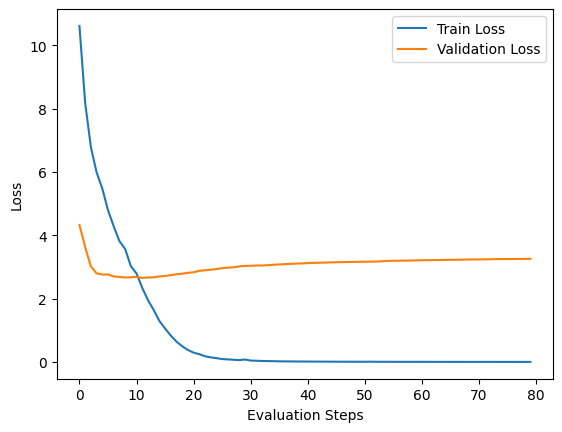

In [53]:
# Want the matplotlib to plot to show 2 line plots in the same graph [with differnet colors]
# X_1, Y_1 and X_2, Y_2

import matplotlib.pyplot as plt
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Evaluation Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
# From Book:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    # print(decoded_text.replace("\n", " "))  # Compact print format
    print(decoded_text.replace("\n", "🦁"))  # Compact print format
    model.train()


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen



# LLM Training:=>
# torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 50 #10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_dataloader, val_dataloader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 10.635, Val loss 10.854
Ep 1 (Step 000005): Train loss 8.145, Val loss 9.034
Every effort moves you, the, the,,, the,, the, the, the,,,,,,, the,,,,,, the,,,,,,,,, the,,, the,,,, the,
Ep 2 (Step 000010): Train loss 6.835, Val loss 7.606
Ep 2 (Step 000015): Train loss 6.014, Val loss 7.016
Every effort moves you,,, the,,,, the,, the the,,,,,,,,, the,,,,,, the,,,,,,,,, the,,,,,,,,,,
Ep 3 (Step 000020): Train loss 5.568, Val loss 6.932
Every effort moves you of the.🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁
Ep 4 (Step 000025): Train loss 4.868, Val loss 6.904
Ep 4 (Step 000030): Train loss 4.365, Val loss 6.772
Every effort moves you of the the.🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁
Ep 5 (Step 000035): Train loss 3.904, Val loss 6.745
Every effort moves you of the picture. I had been, I had been a a, in a. Gisburn's, and I had been, in a, and in the a of it. I was his, and his, and, and, in the
Ep 6 (Step 000040): Train loss 3.662, Val loss 6.704

In [4]:
# Revising:
tokenizer = tiktoken.get_encoding('gpt2')
model = GPTModel(GPT_CONFIG_124M)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

EPOCHS = 30
train_losses = []
val_losses = []
for epoch in range(EPOCHS):
    total_loss = 0.0
    model.train()
    for input_batch, target_batch in train_dataloader:
        optimizer.zero_grad()
        logits = model(input_batch.to(device))
        loss = torch.nn.functional.cross_entropy(
            logits.flatten(0, 1), 
            target_batch.to(device).flatten()
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation Loss
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for input_batch, target_batch in val_dataloader:
            logits = model(input_batch.to(device))
            loss = torch.nn.functional.cross_entropy(
                logits.flatten(0, 1), 
                target_batch.to(device).flatten()
            )
            total_loss += loss.item()
    avg_val_loss = total_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Generate-Sample:
    model.eval()
    start_context = "the verdict is a great piece by"
    encodings = tokenizer.encode(start_context)
    input_tensor = torch.tensor(encodings).unsqueeze(0).to(device)
    max_new_tokens = 30
    context_length = model.pos_emb.weight.shape[0] # 256
    for _ in range(max_new_tokens):
        with torch.no_grad():
            logits = model(input_tensor[:, -context_length:])
        next_token_logits = logits[:, -1, :]
        # next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
        next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
        input_tensor = torch.cat((input_tensor, next_token), dim=-1)
    generated_text = tokenizer.decode(input_tensor.squeeze().tolist())
    print(generated_text.replace('\n', ' '))

the verdict is a great piece by                              
the verdict is a great piece by, I the, the, the, the, the, I, the, the, the, the, the, the, the, the the
the verdict is a great piece by, and I had the to the the, and, and I had the--"--and to me to the. Gisburn, and that
the verdict is a great piece by a of the Mrs.                         
the verdict is a great piece by my--and I had to me, in the, in a little, in a little, in a little, and in a. "Oh
the verdict is a great piece by my dear, and he was ", I had been--and I had given up his pictures!          
the verdict is a great piece by my dear, a he was "interesting": on the last he was dead." "I must, I had been the: ", and his
the verdict is a great piece by my surprise, for he was "interesting": on the last word.                
the verdict is a great piece by my surprise, for he had been the fact with equanimity. Gisburn's past! The women had made him--it was fitting that
the verdict is a great piece by my surpr

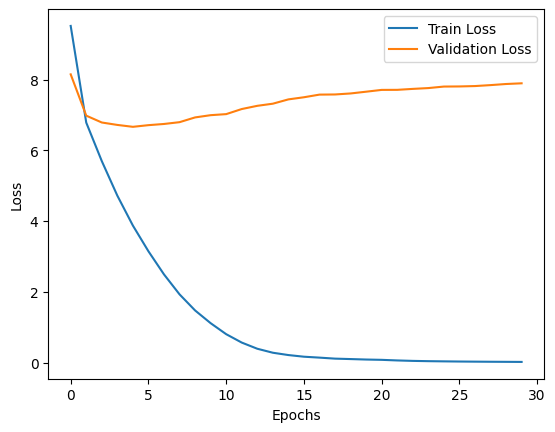

In [5]:
import matplotlib.pyplot as plot
plot.plot(range(len(train_losses)), train_losses, label='Train Loss')
plot.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plot.xlabel('Epochs')
plot.ylabel('Loss')
plot.legend()
plot.show()